<a href="https://colab.research.google.com/github/1028Luo/ML-STUDY-NOTES/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Transformer implementation from scratch with PyTorch
# https://medium.com/towards-data-science/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb

In [ ]:
import torch
import torch.nn as nn

# Multi-Head Attention


In [ ]:
class MultiHeadAttention(nn.module):
  def __init__(self, d_model, num_heads):

    # super(child_class).some_function(): accessing some function in the parent class
    super(MultiHeadAttention, self).__init__()

    assert d_model % num_heads == 0, "d_model must be divisble by num heads"

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads # dimension of each head

    # learnable parameters
    self.W_q = nn.Linear(d_model, d_model) # projects input embeddings to query vector
    self.W_k = nn.Linear(d_model, d_model) # key vector
    self.W_v = nn.Linear(d_model, d_model) # value vector
    self.W_o = nn.Linear(d_model, d_model) #

  def scaled_dot_product_attention(self, Q, K, V, mask=None):

    # Q x K / sqrt(dim_k)
    attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

    if mask is not None:
      # replace with a very small value so it is ignored by softmax
      attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

    attn_probs = torch.softmax(attn_scores, dim = -1)
    output = torch.matmul(attn_probs, V) # multiply with V

    return output

  # split x, dim(x) = d_model = d_k * num_heads
  def split_heads(self, x):
    batch_size, seq_length, d_model = x.size()
    # x.view() reshapes x
    # transpose to swap the 2nd and 3rd dimensions
    return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1,2)

  # combining the results of each head into a single tensor
  # .contiguous(): ensures that the tensor is stored in a contiguous block of memory.
  # This is necessary before calling .view() because transpose() can sometimes return a non-contiguous tensor.
  def combine_heads(self, x):
    batch_size, _, seq_length, d_k = x.size()
    return x.transpose(1,2).contiguous().view(batch_size, seq_length, self.d_model)

  def forward(self, Q, K, V, mask = None):

    # transforms Query Q into the space of d_model and then split into heads
    Q = self.split_heads(self.W_q(Q))
    K = self.split_heads(self.W_q(K))
    V = self.split_heads(self.W_q(V))

    attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
    output = self.W_o(self.combine_heads(attn_output))

    return output


# (FNN) Position-wise Feed-Forward Networks

In [ ]:
# FNN is what follows attention
# also where "facts" are stored in the model
# a very good explanation of FNN, model # parameters and the scaling law
# https://www.youtube.com/watch?v=9-Jl0dxWQs8

# This is a position-wise feed-forward network used in Transformers.
# It expands the input representation (d_model → d_ff), applies ReLU, and then projects it back (d_ff → d_model).
# It is applied independently to each token in the sequence.
# It introduces non-linearity and rich feature transformations, helping the model learn better representations.

class PositionWiseFeedForward(nn.module):
  def __init__(self, d_model, d_ff):
    super(PositionWiseFeedForward, self).__init__()

    self.fc1 = nn.Linear(d_model, d_ff)
    self.fc2 = nn.Linear(d_ff, d_model)
    self.relu = nn.ReLU()

  def forward(self, x):
    return  self.fc2(self.relu(self.fc1((x))))


# PositionalEncoding

In [1]:
# Positional Encoding
# Encodes position information into the embedding

class PositionalEncoding(nn.module):
  def __init__(self, d_model, max_seq_length):
    super(PositionalEncoding, self).__init__()

    pe = torch.zeros(max_seq_length, d_model)

    position = torch.arange(0,max_seq_length, dtype = torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    # stores the positional encoding without making it a learnable parameter.
    # pe.unsqueeze(0) adds a batch dimension, so the final shape is [1, max_seq_length, d_model].
    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
      return x + self.pe[:, :x.size(1)]

NameError: name 'nn' is not defined

# Encoder

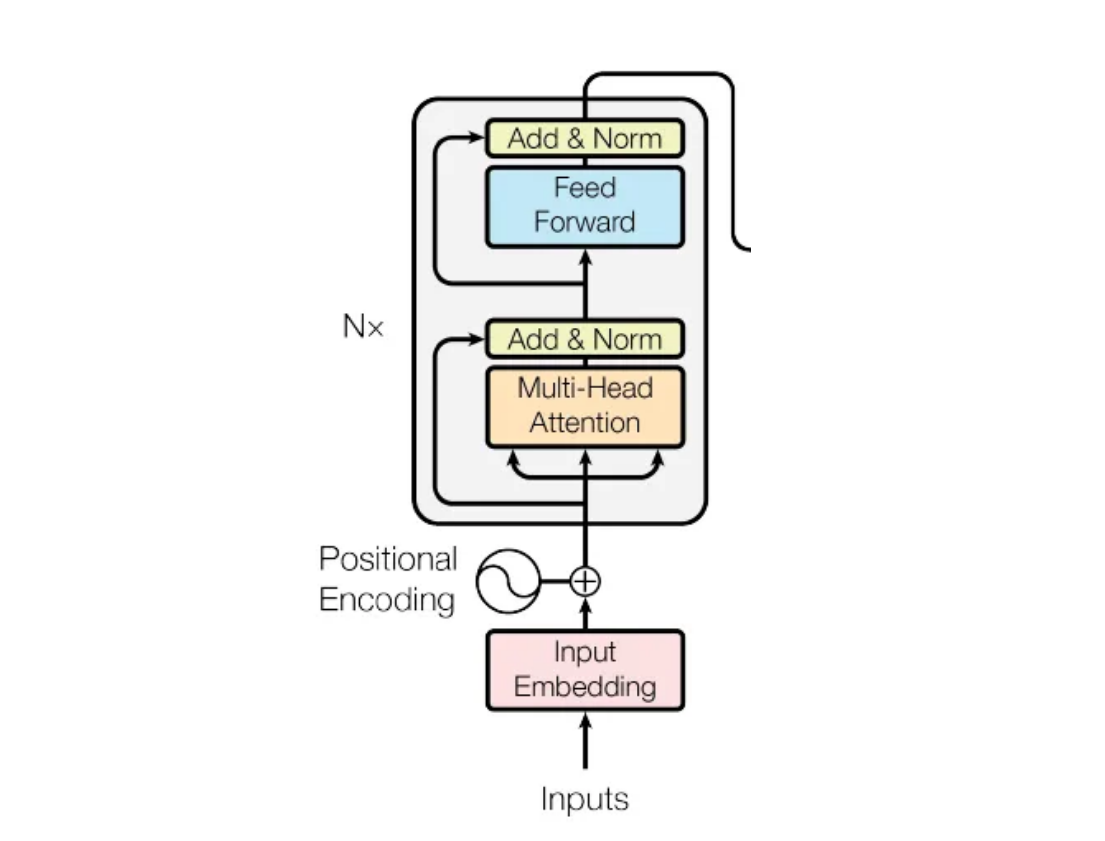

In [ ]:
# Encoder is essentailly attention + FNN
# it is called encoder because it encodes imformation into the model
# Encoder outputs embeddeings
#
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super(EncoderLayer, slef).__init__()
    self.self_attn = MultiHeadAttention(d_model, num_heads)
    self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
    self.norm1 = nn.LayerNorm(d_model) # normalize activations across different input sequences.
    self.norm2 = nn.LayerNorm(d_model) # stabilize training
    self.dropout = nn.Dropout(dropout) # Dropout helps prevent overfitting by randomly deactivating some neurons during training.

  def forward(self, x, mask):
    attn_output = self.self_attn(x, x, x, mask) # self_attn: forward(Q, K, V, mask)
    x = self.norm1(x + self.dropout(attn_output))
    ff_output = self.feed_forward(x)
    x = self.norm2(x + self.dropout(ff_output))
    return x

# Decoder Layer

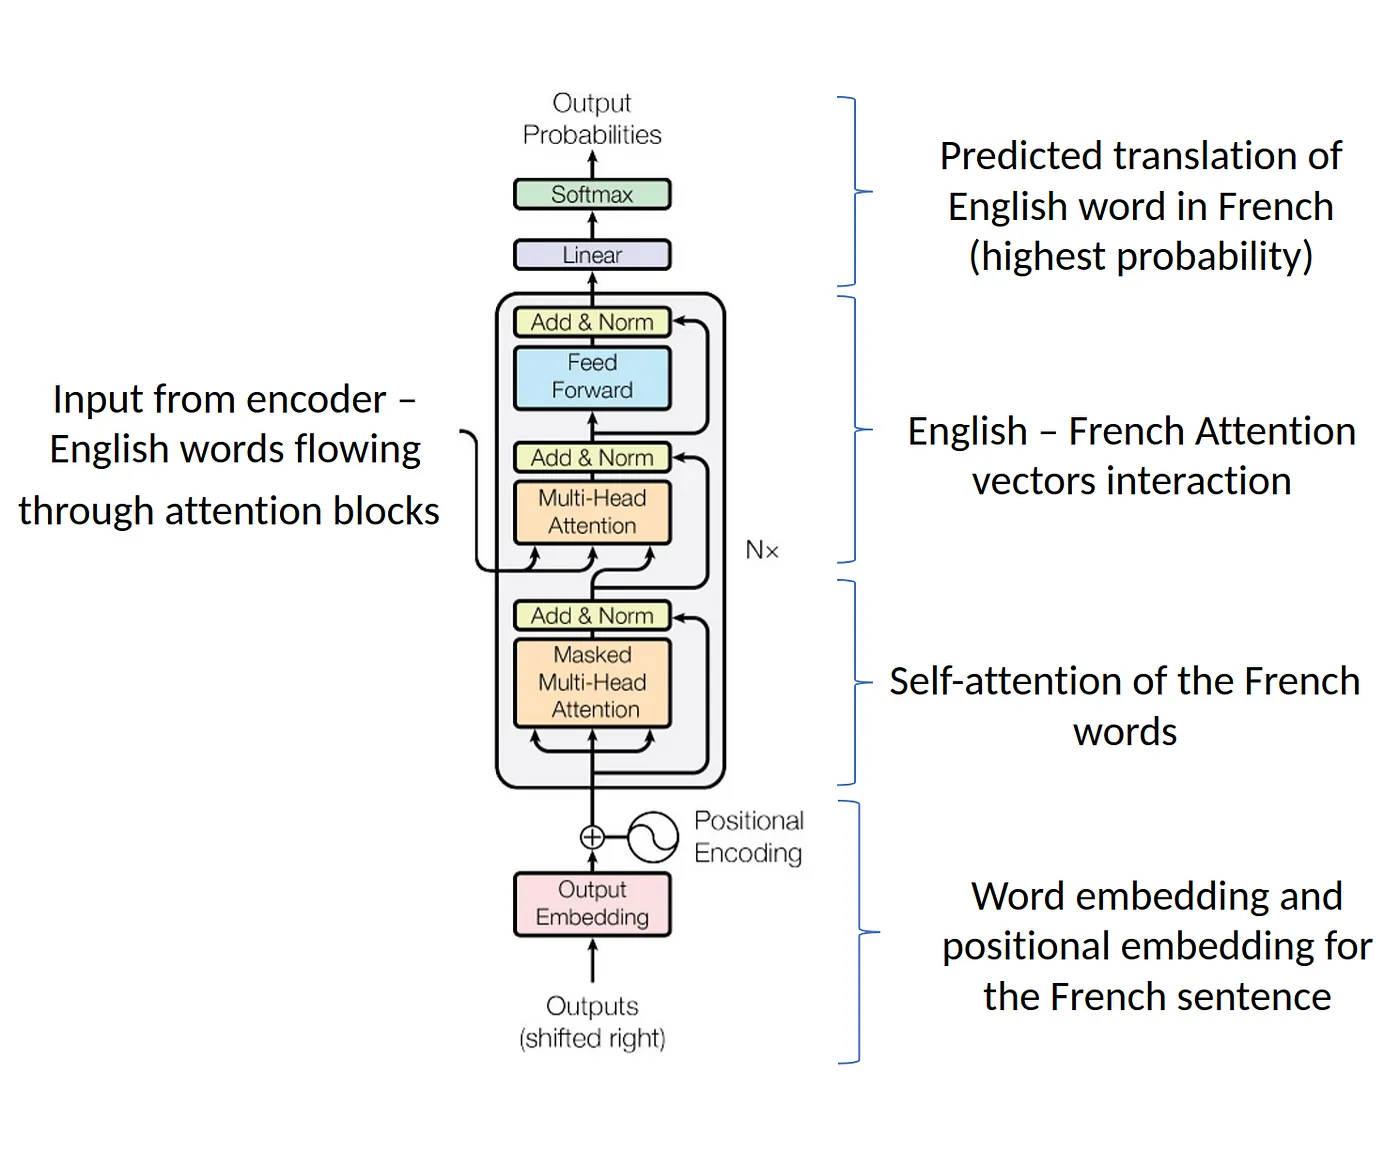

In [ ]:

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        # do cross attention with encoder output and the decoder input
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

# Transformer

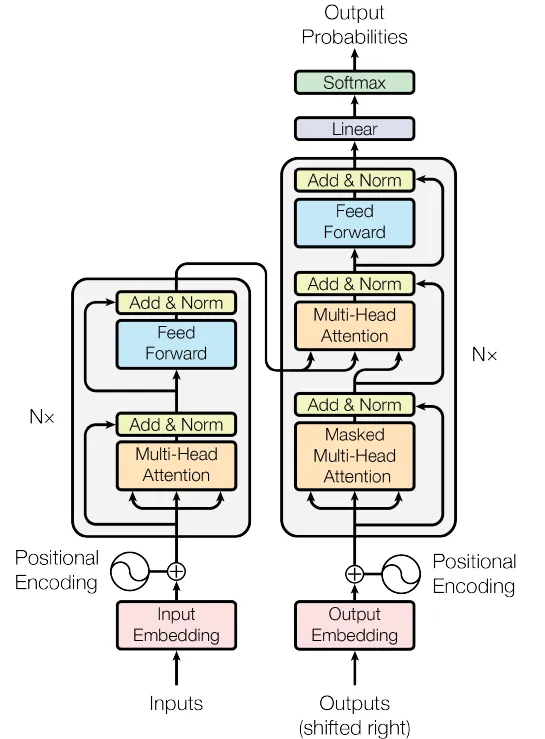

In [ ]:
#

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()

        # nn embedding
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # stack layers
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output